# Info

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

# Libraries Import

In [ ]:
import glob
import cv2
import tqdm

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import kagglehub

In [ ]:
import os
from collections import Counter
import random
import re
import json
import pickle

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization, Concatenate
from tensorflow.keras.layers import AvgPool2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from tensorflow.keras import backend as K


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
from concurrent.futures import ThreadPoolExecutor


# Constants

In [ ]:
IMG_W = 224
IMG_H = 224

EPOCHS = 50
BATCH_SIZE = 32

VAL_SPLIT = 0.2
TEST_SPLIT = 0.2

BASE_DIR = r''

RONDOM_STATE = 42
np.random.seed(RONDOM_STATE)

# Functions

In [ ]:
def save_obj(obj, file_name):
    with open(file_name, 'wb') as f:
        pickle.dump(obj, f)

def load_obj(file_name):
    with open(file_name, 'rb') as f:
        return pickle.load(f)

# Dataset Download

In [ ]:
# Download latest version
dataset_path = kagglehub.dataset_download("balabaskar/tom-and-jerry-image-classification")

print("Path to dataset files:", dataset_path)

Path to dataset files: C:\Users\yosef\.cache\kagglehub\datasets\balabaskar\tom-and-jerry-image-classification\versions\3


# Dataset Read

In [ ]:
images_path = os.path.join(dataset_path, 'tom_and_jerry','tom_and_jerry')

In [ ]:
def load_paths_from_folder(folder_path, desc="Loading images"):
    EXTENSIONS = ['jpeg', 'png', 'jpg']
    images_paths = []

    for ext in EXTENSIONS:
        images_paths += glob.glob(os.path.join(folder_path, f'*/*.{ext}'))

    random.shuffle(images_paths)

    labels = []

    for img_path_i in tqdm.tqdm(images_paths, desc=desc):
        label_i = img_path_i.split(os.path.sep)[-2]
        labels.append(label_i)

    return images_paths, labels

In [ ]:
X_paths, labels = load_paths_from_folder(images_path, desc="Loading images")

Loading images: 100%|██████████| 5478/5478 [00:00<00:00, 568891.68it/s]


# Exploration & Visualization

In [ ]:
print(f"Total images: {len(X_paths)}")
print(f"Total labels: {len(labels)}")

Total images: 5478
Total labels: 5478


In [ ]:
for i in np.random.randint(0, len(X_paths), 20):
    print(f"Image[{i:05d}] Shape:", cv2.imread(X_paths[i]).shape)

Image[00860] Shape: (480, 854, 3)
Image[05390] Shape: (480, 854, 3)
Image[05226] Shape: (480, 854, 3)
Image[05191] Shape: (480, 854, 3)
Image[03772] Shape: (480, 854, 3)
Image[03092] Shape: (720, 1280, 3)
Image[00466] Shape: (720, 1280, 3)
Image[05334] Shape: (480, 854, 3)
Image[04426] Shape: (720, 1280, 3)
Image[03444] Shape: (480, 854, 3)
Image[03171] Shape: (480, 854, 3)
Image[02919] Shape: (480, 854, 3)
Image[00130] Shape: (480, 854, 3)
Image[01685] Shape: (480, 854, 3)
Image[00769] Shape: (720, 1280, 3)
Image[02391] Shape: (720, 1280, 3)
Image[02433] Shape: (720, 1280, 3)
Image[05311] Shape: (480, 854, 3)
Image[05051] Shape: (720, 1280, 3)
Image[01184] Shape: (480, 854, 3)


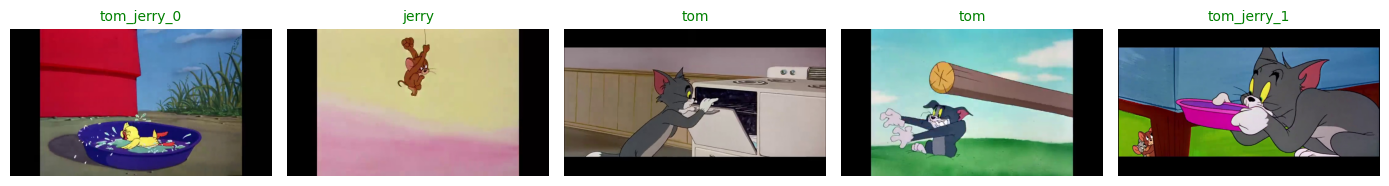

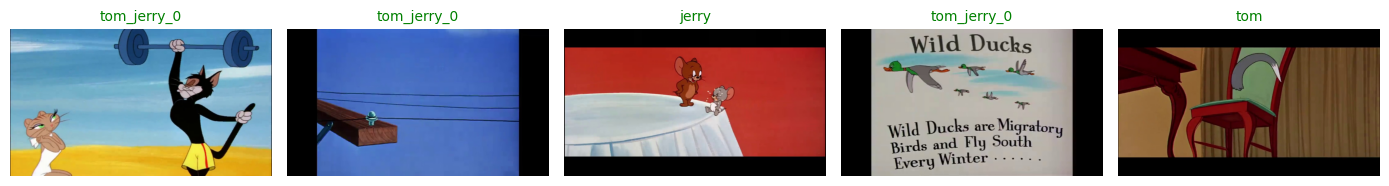

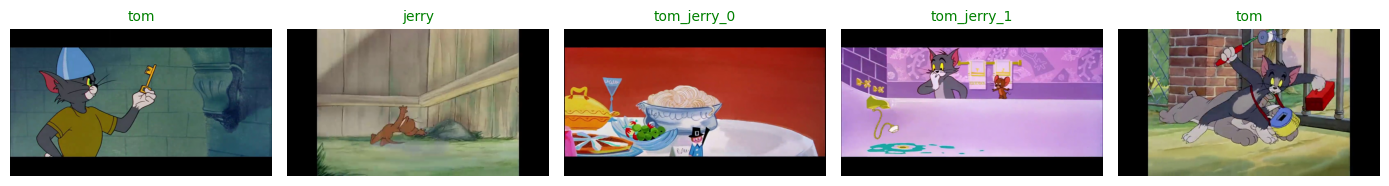

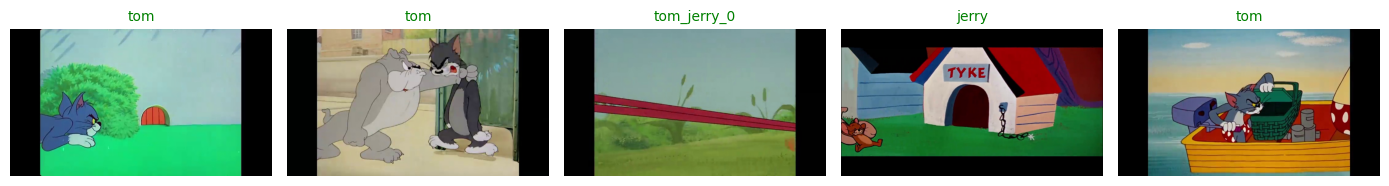

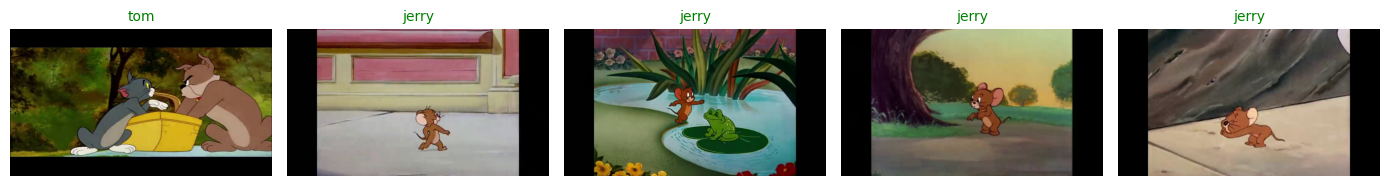

In [ ]:
N_ROWS = 5
N_COLS = 5

for i in range(0, N_ROWS):
    fig, axs = plt.subplots(1, N_COLS, figsize=(14, 14))

    for j in range(N_COLS):
            id_j = np.random.randint(0, len(X_paths))
            img_path_i = X_paths[id_j]
            label_i = labels[id_j]
            img_i = cv2.imread(img_path_i, 1)
            img_i = cv2.cvtColor(img_i, cv2.COLOR_BGR2RGB)

            axs[j].imshow(img_i)
            axs[j].set_title(f"{label_i}", fontsize=10, color='green')
            axs[j].axis('off')

    fig.tight_layout()
    plt.show()

# Labels Preprocessing

In [ ]:
def process_label(label):
    label = str(label).lower().strip()
    return label

In [ ]:
labels_processed = [process_label(label) for label in tqdm.tqdm(labels, desc="Processing labels")]

Processing labels: 100%|██████████| 5478/5478 [00:00<00:00, 1826277.51it/s]


In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(labels_processed)

LabelEncoder()

In [ ]:
N_CLASSES = len(label_encoder.classes_)
print(f"Classes ({N_CLASSES}):", label_encoder.classes_)

Classes (4): ['jerry' 'tom' 'tom_jerry_0' 'tom_jerry_1']


In [ ]:
y = label_encoder.transform(labels_processed)
y = np.array(y)

In [ ]:
print(f"{y.shape = }")

y.shape = (5478,)


In [ ]:
for i, count in Counter(y).items():
    print(f"Label {i:<2} ({label_encoder.classes_[i]:<14}): {count:<6} samples")

Label 1  (tom           ): 1930   samples
Label 2  (tom_jerry_0   ): 1528   samples
Label 3  (tom_jerry_1   ): 780    samples
Label 0  (jerry         ): 1240   samples


# Images Preprocessing

Blur Filters

In [ ]:
# # make image smooth
# def apply_filter_gaussian(image, kernel_size=(5, 5), sigma=0):
#     return cv2.GaussianBlur(image, kernel_size, sigma).astype(image.dtype)

# # remove salt and pepper noise
# def apply_filter_median(image, kernel_size=5):
#     return cv2.medianBlur(image, kernel_size).astype(image.dtype)

# # preserve edges while reducing noise
# def apply_filter_bilateral(image, d=9, sigma_color=75, sigma_space=75):
#     return cv2.bilateralFilter(image, d, sigma_color, sigma_space).astype(image.dtype)

Edge Detection

In [ ]:
# def apply_laplacian(image, ksize=3):
#     return cv2.Laplacian(image, cv2.CV_32F, ksize=ksize).astype(image.dtype)

# def apply_sobel(image, dx=1, dy=0, ksize=3):
#     return cv2.Sobel(image, cv2.CV_32F, dx, dy, ksize=ksize).astype(image.dtype)

# def apply_canny(image, threshold1=50, threshold2=60):
#     return cv2.Canny(image, threshold1, threshold2).astype(image.dtype)

Kmeans

In [ ]:
# def apply_kmeans(image, n_colors=12):
#     n_channels = image.shape[2] if len(image.shape) == 3 else 1

#     Z = image.reshape((-1, n_channels)).astype(np.float32)

#     criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
#     _, label, center = cv2.kmeans(Z, n_colors, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

#     center = np.uint8(center)
#     res = center[label.flatten()]
#     clustered = res.reshape(image.shape)
#     return clustered

In [ ]:
def preprocess_image_from_path(image_path):
    image = cv2.imread(image_path, 1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Resize the image to the target dimensions
    image = cv2.resize(image, (IMG_W, IMG_H))

    # Ensure the image has channel dimension
    if len(image.shape) == 2:
        image = np.reshape(image, (IMG_W, IMG_H, 1))

    # image = apply_filter_median(image)

    # append new channel for kmean
    # image = np.stack((image, apply_sobel(image), apply_canny(image)), axis=-1)

    image = (image / 255.0).astype(np.float32)

    image = np.clip(image, 0.0, 1.0)

    return image.astype(np.float32)

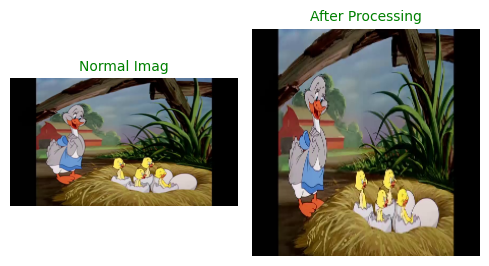

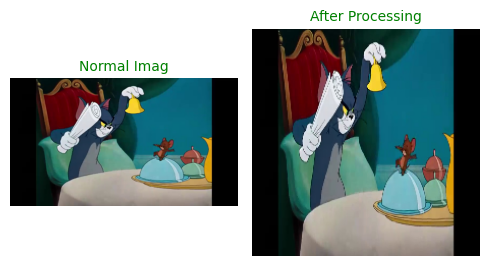

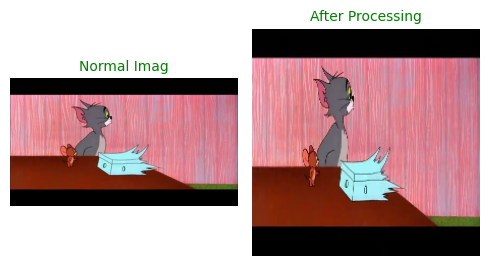

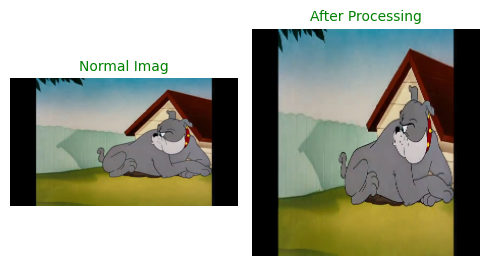

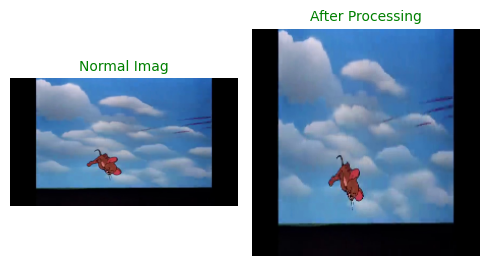

In [ ]:
N_ROWS = 5
IMG_SHAPE = None

for i in range(0, N_ROWS):
    fig, axs = plt.subplots(1, 2, figsize=(5, 5))

    id_j = np.random.randint(0, len(X_paths))
    img_path_i = X_paths[id_j]
    label_i = labels[id_j]

    img_i = cv2.imread(img_path_i, 1)
    img_i = cv2.cvtColor(img_i, cv2.COLOR_BGR2RGB)
    img_i_processed = preprocess_image_from_path(img_path_i)

    axs[0].imshow(img_i.squeeze())
    axs[0].set_title(f"Normal Imag", fontsize=10, color='green')
    axs[0].axis('off')

    axs[1].imshow(img_i_processed)
    axs[1].set_title(f"After Processing", fontsize=10, color='green')
    axs[1].axis('off')

    IMG_SHAPE = img_i_processed.shape

    fig.tight_layout()
    plt.show()

# Data Split

In [ ]:
X_paths_train, X_paths_val, y_train, y_val = train_test_split(X_paths, y, test_size= VAL_SPLIT + TEST_SPLIT, random_state=RONDOM_STATE)

X_paths_val, X_path_test, y_val, y_test = train_test_split(X_paths_val, y_val, test_size= TEST_SPLIT / (VAL_SPLIT + TEST_SPLIT), random_state=RONDOM_STATE)

X_paths_train = np.array(X_paths_train)
X_paths_val = np.array(X_paths_val)
X_paths_test = np.array(X_path_test)

print(f"{X_paths_train.shape = }")
print(f"{X_paths_val.shape = }")
print(f"{X_paths_test.shape = }")

X_paths_train.shape = (3286,)
X_paths_val.shape = (1096,)
X_paths_test.shape = (1096,)


# Data Augmentation

In [ ]:
def custom_augmentation_numpy(image):
    # -----------------------------
    # 1. Random Horizontal Flip
    if np.random.rand() > 0.5:
        image = np.fliplr(image)

    # # -----------------------------
    # # 2. Random Vertical Flip
    # if np.random.rand() > 0.5:
    #     image = np.flipud(image)

    # -----------------------------
    # 3. Random Rotation
    if np.random.rand() > 0.5:
        angle = np.random.uniform(-5, 5)
        h, w = image.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        image = cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REFLECT_101)

    # -----------------------------
    # 4. Random Crop and Resize Back
    if np.random.rand() > 0.5:
        h, w = image.shape[:2]
        crop_scale = np.random.uniform(0.95, 1.0)
        new_h, new_w = int(h * crop_scale), int(w * crop_scale)
        top = np.random.randint(0, h - new_h + 1)
        left = np.random.randint(0, w - new_w + 1)
        image = image[top:top + new_h, left:left + new_w]
        image = cv2.resize(image, (w, h))

    # -----------------------------
    # 5. Random Brightness
    if np.random.rand() > 0.5:
        brightness_shift = np.random.uniform(-0.1, 0.1)
        image = image + brightness_shift
        image = np.clip(image, 0, 1)

    # -----------------------------
    # 6. Random Contrast
    if np.random.rand() > 0.5:
        factor = np.random.uniform(0.8, 1.2)
        mean = image.mean(axis=(0, 1), keepdims=True)
        image = (image - mean) * factor + mean
        image = np.clip(image, 0, 1)

    # -----------------------------
    # 7. Random Gaussian Noise
    if np.random.rand() > 0.5:
        noise = np.random.normal(0, 0.05, image.shape)
        image = image + noise
        image = np.clip(image, 0, 1)

    return image


In [ ]:
# def build_data_generator(
#     image_paths,
#     labels,
#     batch_size=32,
#     augment=True,
#     shuffle=True,
#     n_workers=tf.data.AUTOTUNE,
#     repeat=False,            # <- new
# ):
#     # Keep original list for len()
#     num_samples = len(image_paths)

#     # Convert to tensors after we know num_samples
#     image_paths = tf.convert_to_tensor(image_paths, dtype=tf.string)
#     labels = tf.convert_to_tensor(labels)

#     # Static cache variable
#     if not hasattr(build_data_generator, "_image_cache"):
#         build_data_generator._image_cache = {}
#     cache = build_data_generator._image_cache

#     # Create dataset from tensors
#     ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))

#     # If repeat requested, repeat so we can reshuffle each epoch
#     if repeat:
#         ds = ds.repeat()

#     # Shuffle each epoch (only meaningful when repeat=True, but harmless otherwise)
#     if shuffle:
#         ds = ds.shuffle(buffer_size=num_samples, reshuffle_each_iteration=True)

#     # Python-side loader with caching
#     def load_and_preprocess_py(path, label):
#         # path arrives as bytes in numpy_function -> decode
#         path_str = path.decode("utf-8")

#         if path_str in cache:
#             image = cache[path_str]
#         else:
#             image = preprocess_image_from_path(path_str)
#             cache[path_str] = image

#         if augment:
#             image = custom_augmentation_numpy(image)

#         # return numpy arrays / scalars
#         return image.astype(np.float32), np.int32(label)

#     # Wrap in tf.numpy_function so we can run Python/NumPy code
#     def tf_wrapper(path, label):
#         image, lbl = tf.numpy_function(
#             func=load_and_preprocess_py,
#             inp=[path, label],
#             Tout=[tf.float32, tf.int32]
#         )
#         # set static shape so TF can batch properly
#         image.set_shape([IMG_H, IMG_W, 3])
#         lbl.set_shape([])  # scalar label
#         return image, lbl

#     # Map with parallel calls
#     ds = ds.map(tf_wrapper, num_parallel_calls=n_workers)

#     # Batch + prefetch
#     ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
#     return ds



In [ ]:
class MyDataGenerator(Sequence):
    _image_cache = {}  # static cache shared by all instances

    def __init__(self, images_paths, labels, batch_size=32, augment=True, shuffle=True, n_workers=4):
        self.images_paths = np.array(images_paths)
        self.labels = np.array(labels)
        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle
        self.n_workers = n_workers
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.images_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_x = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images_paths = self.images_paths[batch_x]
        batch_labels = self.labels[batch_x]

        batch_images = self._load_images_parallel(batch_images_paths)

        if self.augment:
            batch_images = np.stack([custom_augmentation_numpy(img) for img in batch_images], axis=0)

        return batch_images, batch_labels

    def on_epoch_end(self):
        self.indices = np.arange(len(self.images_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def _load_images_parallel(self, paths):
        with ThreadPoolExecutor(max_workers=self.n_workers) as executor:
            images = list(executor.map(self._load_and_preprocess_single, paths))
        return np.stack(images, axis=0)

    def _load_and_preprocess_single(self, path):
        if path in MyDataGenerator._image_cache:
            return MyDataGenerator._image_cache[path]

        img = preprocess_image_from_path(path)
        MyDataGenerator._image_cache[path] = img
        return img


In [ ]:
train_generator = MyDataGenerator(X_paths_train, y_train,
                                       batch_size=BATCH_SIZE, augment=True, shuffle=True)   
train_pure_generator = MyDataGenerator(X_paths_train, y_train,
                                            batch_size=BATCH_SIZE, augment=False, shuffle=False)
val_generator = MyDataGenerator(X_paths_val, y_val,
                                     batch_size=BATCH_SIZE, augment=False, shuffle=False) 

test_generator = MyDataGenerator(X_paths_test, y_test,
                                      batch_size=BATCH_SIZE, augment=False, shuffle=False)  


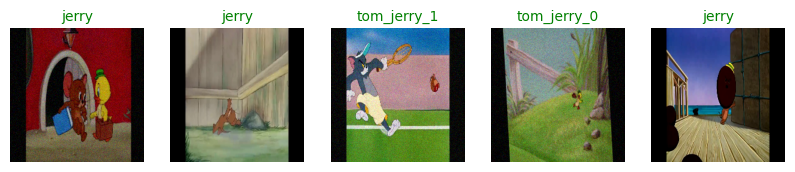

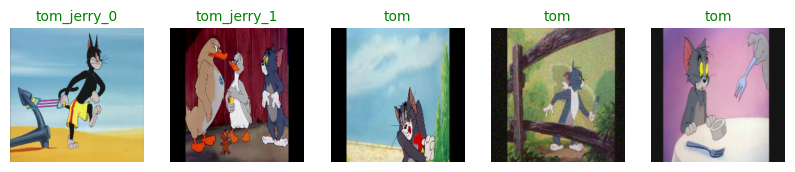

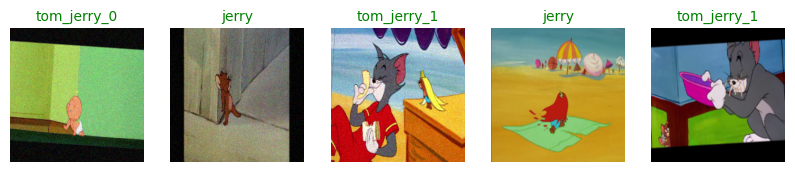

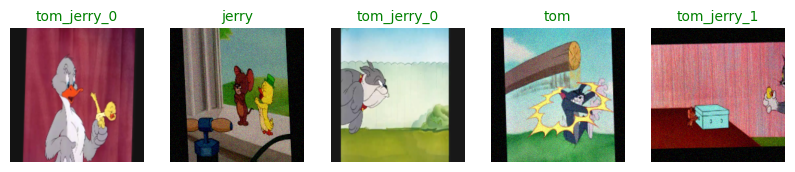

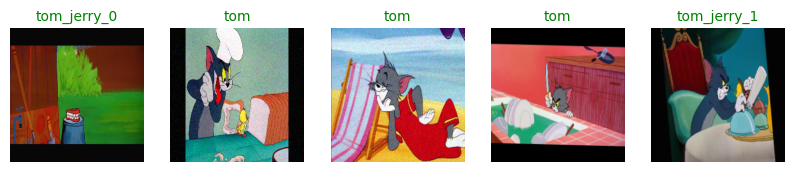

In [ ]:
N_COLS = 5
N_ROWS = 5

batch_i = train_generator[np.random.randint(0, len(train_generator) - 1)]
N_SAMPLES = batch_i[0].shape[0]

i_counter = 0
for i in range(N_ROWS):
    fig, axs = plt.subplots(1, N_COLS, figsize=(10, 10))

    for j in range(N_COLS):
        if i_counter >= N_SAMPLES:
            break

        img_i = batch_i[0][i_counter]
        label_i = batch_i[1][i_counter]

        axs[j].imshow(img_i)
        axs[j].set_title(f"{label_encoder.classes_[label_i]}", fontsize=10, color='green')
        axs[j].axis('off')

        i_counter += 1    

# Model Encapsulation

In [ ]:
CACHE_MODELS_DIR_NAME = os.path.join(BASE_DIR, 'models_cache')
os.makedirs(CACHE_MODELS_DIR_NAME, exist_ok=True)

In [ ]:
class HistoryCheckpoint(Callback):
    def __init__(self, model_name):
        super().__init__()
        self.model_name = model_name
        self.filepath = os.path.join(CACHE_MODELS_DIR_NAME, f'{model_name}.history.json')
        self.history = {}

        if os.path.exists(self.filepath):
            with open(self.filepath, 'r') as f:
                self.history = json.load(f)
                print(F'Model {self.model_name} history loaded from cache')
        else:
            self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for key, value in logs.items():
            self.history.setdefault(key, []).append(float(value))

        with open(self.filepath, 'w') as f:
            json.dump(self.history, f)

    def get_history(self):
        return self.history

In [ ]:
# --- CustomModel.fit: don't forward batch_size to self.model.fit ---
class CustomModel:
    def __init__(self, name, model):
        self.name = re.sub('[^A-Za-z0-9]', '_', str(name)).lower()
        self.model = model
        self._history = {}
        self.load()

    def fit(self, data_gen, validation_data, epochs, batch_size=None, force_train=False,
            class_weights=None, steps_per_epoch=None, validation_steps=None):
        file_path = CACHE_MODELS_DIR_NAME + '/' + self.name + '.weights.h5'
        es = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
        mcp = ModelCheckpoint(filepath=file_path, monitor='val_loss', save_best_only=True,
                              save_weights_only=True, mode='min', verbose=1)
        rop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
        hcp = HistoryCheckpoint(self.name)

        if self.trained == False or force_train:
            # IMPORTANT: do NOT pass batch_size here when data_gen is a tf.data.Dataset
            self.model.fit(
                data_gen,
                validation_data=validation_data,
                callbacks=[es, mcp, rop, hcp],
                epochs=epochs,
                steps_per_epoch=steps_per_epoch,
                validation_steps=validation_steps,
                class_weight=class_weights
            )

            self.trained = True
            self._history = hcp.get_history()
        else:
            self._history = hcp.get_history()

    @property
    def history(self):
        return self._history

    def save(self):
        file_path = CACHE_MODELS_DIR_NAME + '/' + self.name + '.weights.h5'
        self.model.save_weights(file_path)

    def load(self):
        file_path = CACHE_MODELS_DIR_NAME + '/' + self.name + '.weights.h5'
        if os.path.exists(file_path):
            self.model.load_weights(file_path)
            self.trained = True
            print(F'Model {self.name} weights loaded from cache')
        else:
            self.trained = False
            print(F'Model {self.name} weights not found in cache, training required')
        hcp = HistoryCheckpoint(self.name)
        self._history = hcp.get_history()


# Models Arch

In [ ]:
models_list = list()

In [ ]:
def build_model_1():
    global models_list
    NAME = "cnn_v1"
    
    model = Sequential()
    model.add(Input(shape= IMG_SHAPE))

    model.add(Conv2D(32, (3, 3), activation='relu', padding='valid'))
    model.add(AvgPool2D((2, 2)))

    model.add(Conv2D(64, (4, 4), activation='relu', padding='valid'))
    model.add(AvgPool2D((3, 3)))

    model.add(Conv2D(128, (6, 6), strides=3, activation=None, padding='valid'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(AvgPool2D((5, 5), strides=(5, 5)))

    model.add(Flatten())

    model.add(Dense(32, activation='relu'))
    model.add(Dense(N_CLASSES, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



    model.summary()
    custom_model =  CustomModel(NAME, model)
    models_list = list(filter(lambda x: x.name != custom_model.name, models_list))
    models_list.append(custom_model)

build_model_1()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 111, 111, 32)   │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 108, 108, 64)   │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 36, 36, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 11, 11, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 11, 11, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 2, 2, 128)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 345,828 (1.32 MB)

 Trainable params: 345,572 (1.32 MB)

 Non-trainable params: 256 (1.00 KB)

Model cnn_v1 weights not found in cache, training required


In [ ]:
for model in models_list:
    if isinstance(model.model, tf.keras.Model):
          keras_model = model.model

          img_path = os.path.join(CACHE_MODELS_DIR_NAME,f'{model.name}_arch.png')

          plot_model(
              keras_model,
              to_file= img_path,
              show_shapes=True,
              dpi =200,
              show_layer_names=True,
              expand_nested=True,
              show_layer_activations=True,
              show_trainable=True,
              show_dtype=True,
          )


# Model Training

In [ ]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = {i: class_weights[i] for i in range(len(class_weights))}

print(f"Class weights: {class_weights}")

Class weights: {0: np.float64(1.0880794701986756), 1: np.float64(0.7118717504332756), 2: np.float64(0.9087389380530974), 3: np.float64(1.736786469344609)}


In [ ]:
steps_per_epoch = int(np.ceil(len(X_paths_train) / BATCH_SIZE))
val_steps = int(np.ceil(len(X_paths_val) / BATCH_SIZE))

print(f"Steps per epoch: {steps_per_epoch}, Validation steps: {val_steps}")

In [ ]:
for i, model in enumerate(models_list):
    print(f"{i+1}. Train: {model.name}")
    model.fit(
        train_generator,                  # data_gen (tf.data.Dataset)
        validation_data=val_generator,    # passed as keyword for clarity
        epochs=50,
        batch_size=None,                  # not forwarded into model.fit (kept for API compatibility)
        class_weights=class_weights,              
        # steps_per_epoch=steps_per_epoch,
        # validation_steps=val_steps,
        force_train=False
    )

1. Train: cnn_v1


c:\Users\yosef\anaconda3\envs\my-env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.3050 - loss: 1.3769
Epoch 1: val_loss improved from inf to 1.37526, saving model to models_cache/cnn_v1.weights.h5
103/103 ━━━━━━━━━━━━━━━━━━━━ 51s 477ms/step - accuracy: 0.3054 - loss: 1.3766 - val_accuracy: 0.2929 - val_loss: 1.3753 - learning_rate: 0.0010
Epoch 2/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.3746 - loss: 1.2889
Epoch 2: val_loss improved from 1.37526 to 1.31681, saving model to models_cache/cnn_v1.weights.h5
103/103 ━━━━━━━━━━━━━━━━━━━━ 45s 432ms/step - accuracy: 0.3747 - loss: 1.2887 - val_accuracy: 0.3412 - val_loss: 1.3168 - learning_rate: 0.0010
Epoch 3/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.4477 - loss: 1.1901
Epoch 3: val_loss improved from 1.31681 to 1.29234, saving model to models_cache/cnn_v1.weights.h5
103/103 ━━━━━━━━━━━━━━━━━━━━ 48s 463ms/step - accuracy: 0.4477 - loss: 1.1901 - val_accuracy: 0.3613 - val_loss: 1.2923 - learning_rate: 0.0010
Epoch 4/50


# History

In [ ]:
plt.style.use(plt.style.available[12])

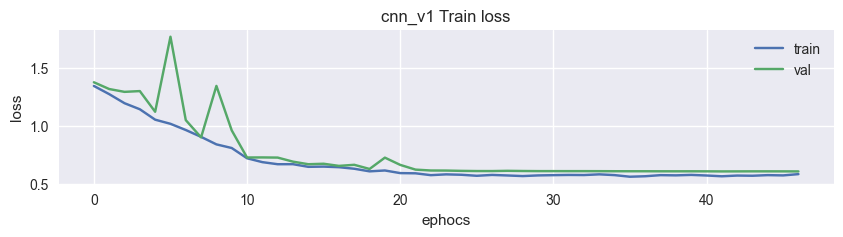

In [ ]:
for i, model in enumerate(models_list):
    plt.figure(figsize=(10,2))
    plt.grid(True)
    plt.title(f"{model.name} Train loss")
    plt.ylabel('loss')
    plt.xlabel('ephocs')
    plt.plot(model.history['loss'], label='train')
    plt.plot(model.history['val_loss'], label='val')
    plt.legend()
    plt.show()

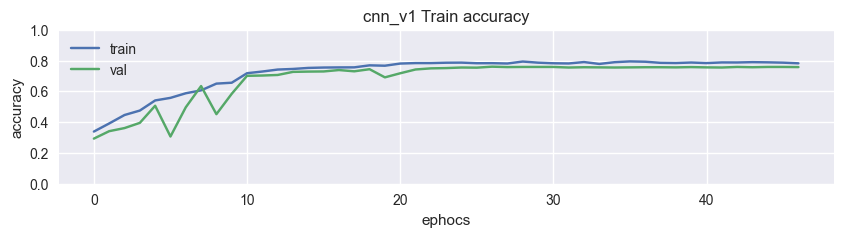

In [ ]:
for i, model in enumerate(models_list):
    plt.figure(figsize=(10,2))
    plt.grid(True)
    plt.title(f"{model.name} Train accuracy")
    plt.ylabel('accuracy')
    plt.xlabel('ephocs')
    plt.plot(model.history['accuracy'], label='train')
    plt.plot(model.history['val_accuracy'], label='val')
    plt.ylim([0, 1])
    plt.legend()
    plt.show()

# Model Eval

In [ ]:
for model in models_list:
    print(f"Model: {model.name}")

    loss, accuracy = model.model.evaluate(train_pure_generator, verbose=1)
    print(f"Train loss: {loss:.4f}")
    print(f"Train accuracy: {accuracy:.4f}")

    loss, accuracy = model.model.evaluate(val_generator, verbose=1)
    print(f"Val loss: {loss:.4f}")
    print(f"Val accuracy: {accuracy:.4f}")

    loss, accuracy = model.model.evaluate(test_generator, verbose=1)
    print(f"Test loss: {loss:.4f}")
    print(f"Test accuracy: {accuracy:.4f}")

    print("\n")


Model: cnn_v1
103/103 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.8162 - loss: 0.5029
Train loss: 0.5009
Train accuracy: 0.8256
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.7454 - loss: 0.6056
Val loss: 0.6050
Val accuracy: 0.7546
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.7808 - loss: 0.5538
Test loss: 0.5790
Test accuracy: 0.7765



# Classification Report

Model: cnn_v1
103/103 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step


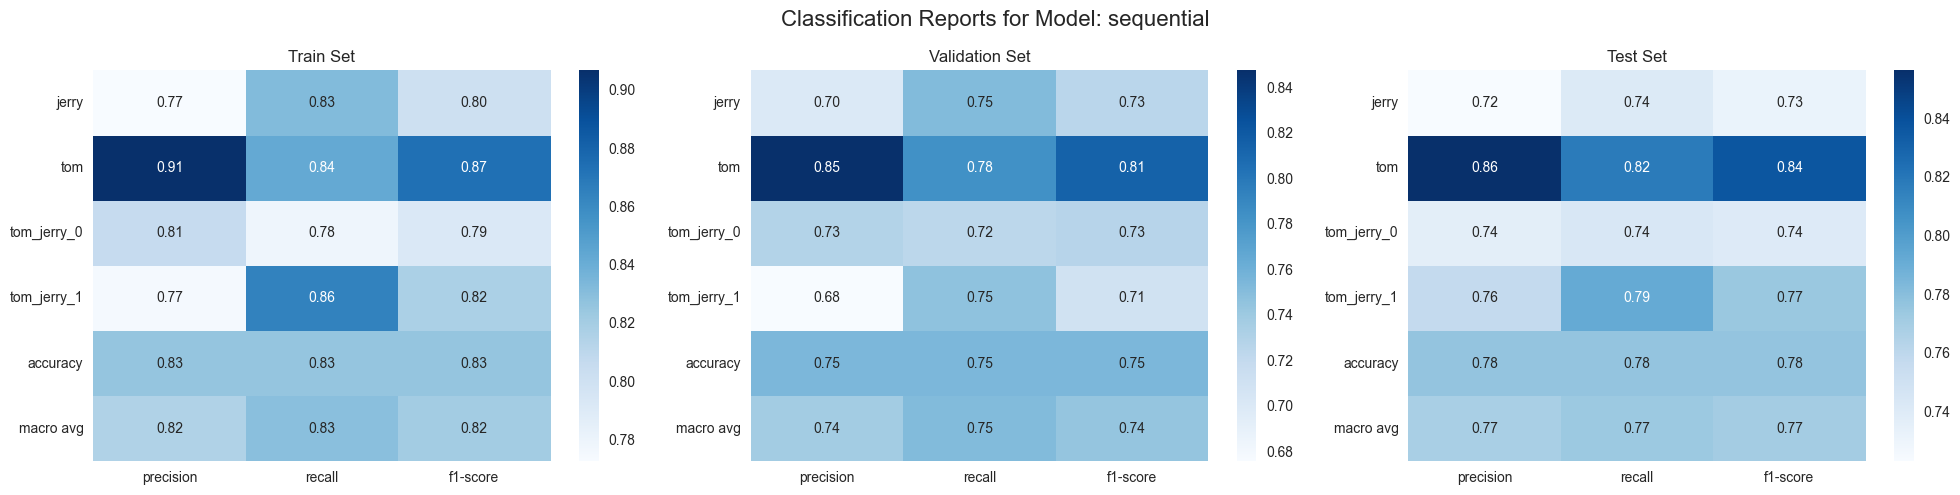

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report

for custom_model in models_list:
    print(f"Model: {custom_model.name}")
    model = custom_model.model

    y_train_hat = np.argmax(model.predict(train_pure_generator), axis=1)
    y_val_hat = np.argmax(model.predict(val_generator), axis=1)
    y_test_hat = np.argmax(model.predict(test_generator), axis=1)

    # Prepare reports
    reports = {
        'Train': classification_report(y_train, y_train_hat, target_names=label_encoder.classes_, output_dict=True,zero_division=0),
        'Validation': classification_report(y_val, y_val_hat, target_names=label_encoder.classes_, output_dict=True,zero_division=0),
        'Test': classification_report(y_test, y_test_hat, target_names=label_encoder.classes_, output_dict=True,zero_division=0),
    }

    # Plot
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))
    fig.suptitle(f'Classification Reports for Model: {model.name}', fontsize=16)

    for ax, (split, report_dict) in zip(axs, reports.items()):
        report_df = pd.DataFrame(report_dict).T.drop(columns=['support'], errors='ignore')
        sns.heatmap(report_df.iloc[:-1, :], annot=True, cmap='Blues', fmt='.2f', ax=ax)
        ax.set_title(f'{split} Set')
        ax.set_xlabel('')
        ax.set_ylabel('')

    plt.tight_layout()
    plt.show()


# Confusion Matrix

103/103 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step


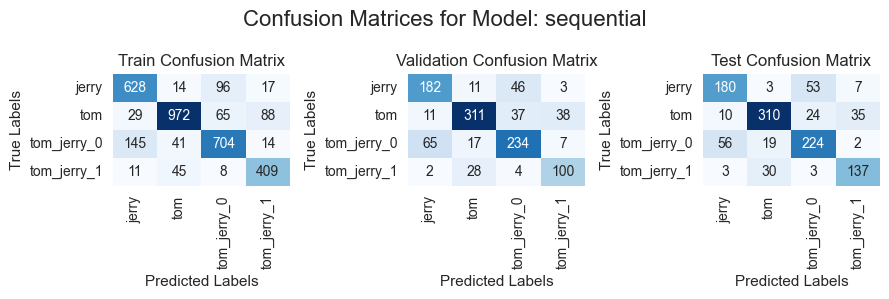

In [ ]:
for custom_model in models_list:
    model = custom_model.model
    
    y_train_hat = np.argmax(model.predict(train_pure_generator), axis=1)
    y_val_hat = np.argmax(model.predict(val_generator), axis=1)
    y_test_hat = np.argmax(model.predict(test_generator), axis=1)

    fig, axs = plt.subplots(1, 3, figsize=(9, 3))

    cm0 = confusion_matrix(y_train, y_train_hat)
    cm1 = confusion_matrix(y_val, y_val_hat)
    cm2 = confusion_matrix(y_test, y_test_hat)

    sns.heatmap(cm0, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axs[0], xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    axs[0].set_title('Train Confusion Matrix')
    axs[0].set_xlabel('Predicted Labels')
    axs[0].set_ylabel('True Labels')

    sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axs[1], xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    axs[1].set_title('Validation Confusion Matrix')
    axs[1].set_xlabel('Predicted Labels')
    axs[1].set_ylabel('True Labels')

    sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axs[2], xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    axs[2].set_title('Test Confusion Matrix')
    axs[2].set_xlabel('Predicted Labels')
    axs[2].set_ylabel('True Labels')

    fig.suptitle(f'Confusion Matrices for Model: {model.name}', fontsize=16)

    plt.tight_layout()
    plt.show()


# Model Explanation

## intermediate features

In [ ]:
def explain_visualize_intermediate_features(model, single_input_image):
    # Add batch dimension
    input_data = np.expand_dims(single_input_image, axis=0)

    # Collect Conv2D outputs
    outputs = [layer.output for layer in model.layers if isinstance(layer, Conv2D)]
    output_names = [layer.name for layer in model.layers if isinstance(layer, Conv2D)]

    # Intermediate model to fetch activations
    intermediate_model = Model(inputs=model.layers[0].input, outputs=outputs)
    intermediate_outputs = intermediate_model.predict(input_data)

    # Return dictionary for further processing
    return {name: output for name, output in zip(output_names, intermediate_outputs)}


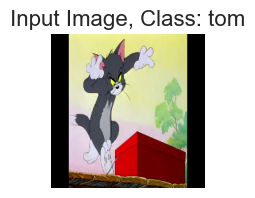

Model: cnn_v1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


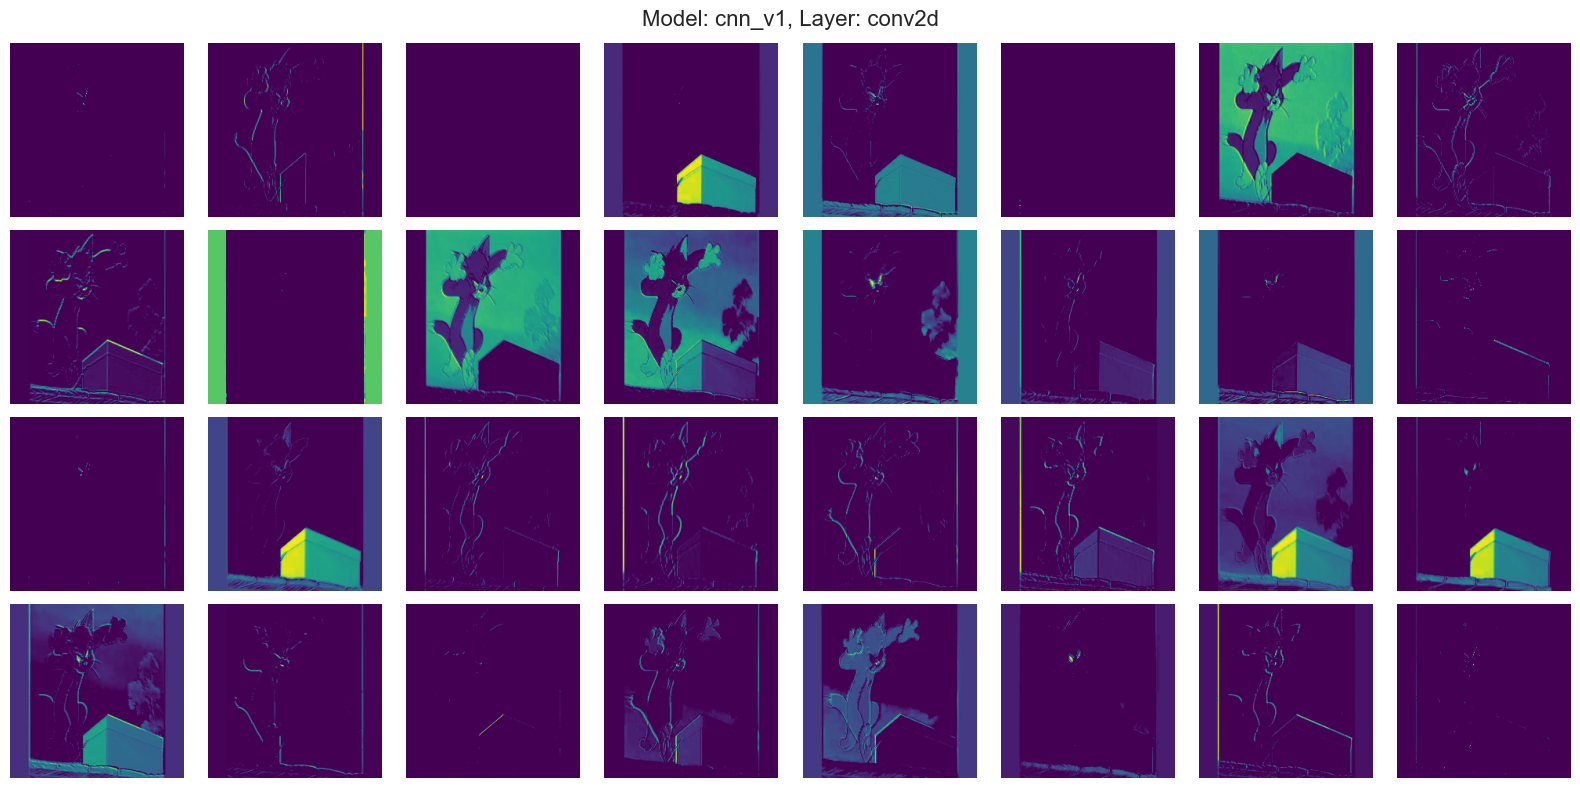

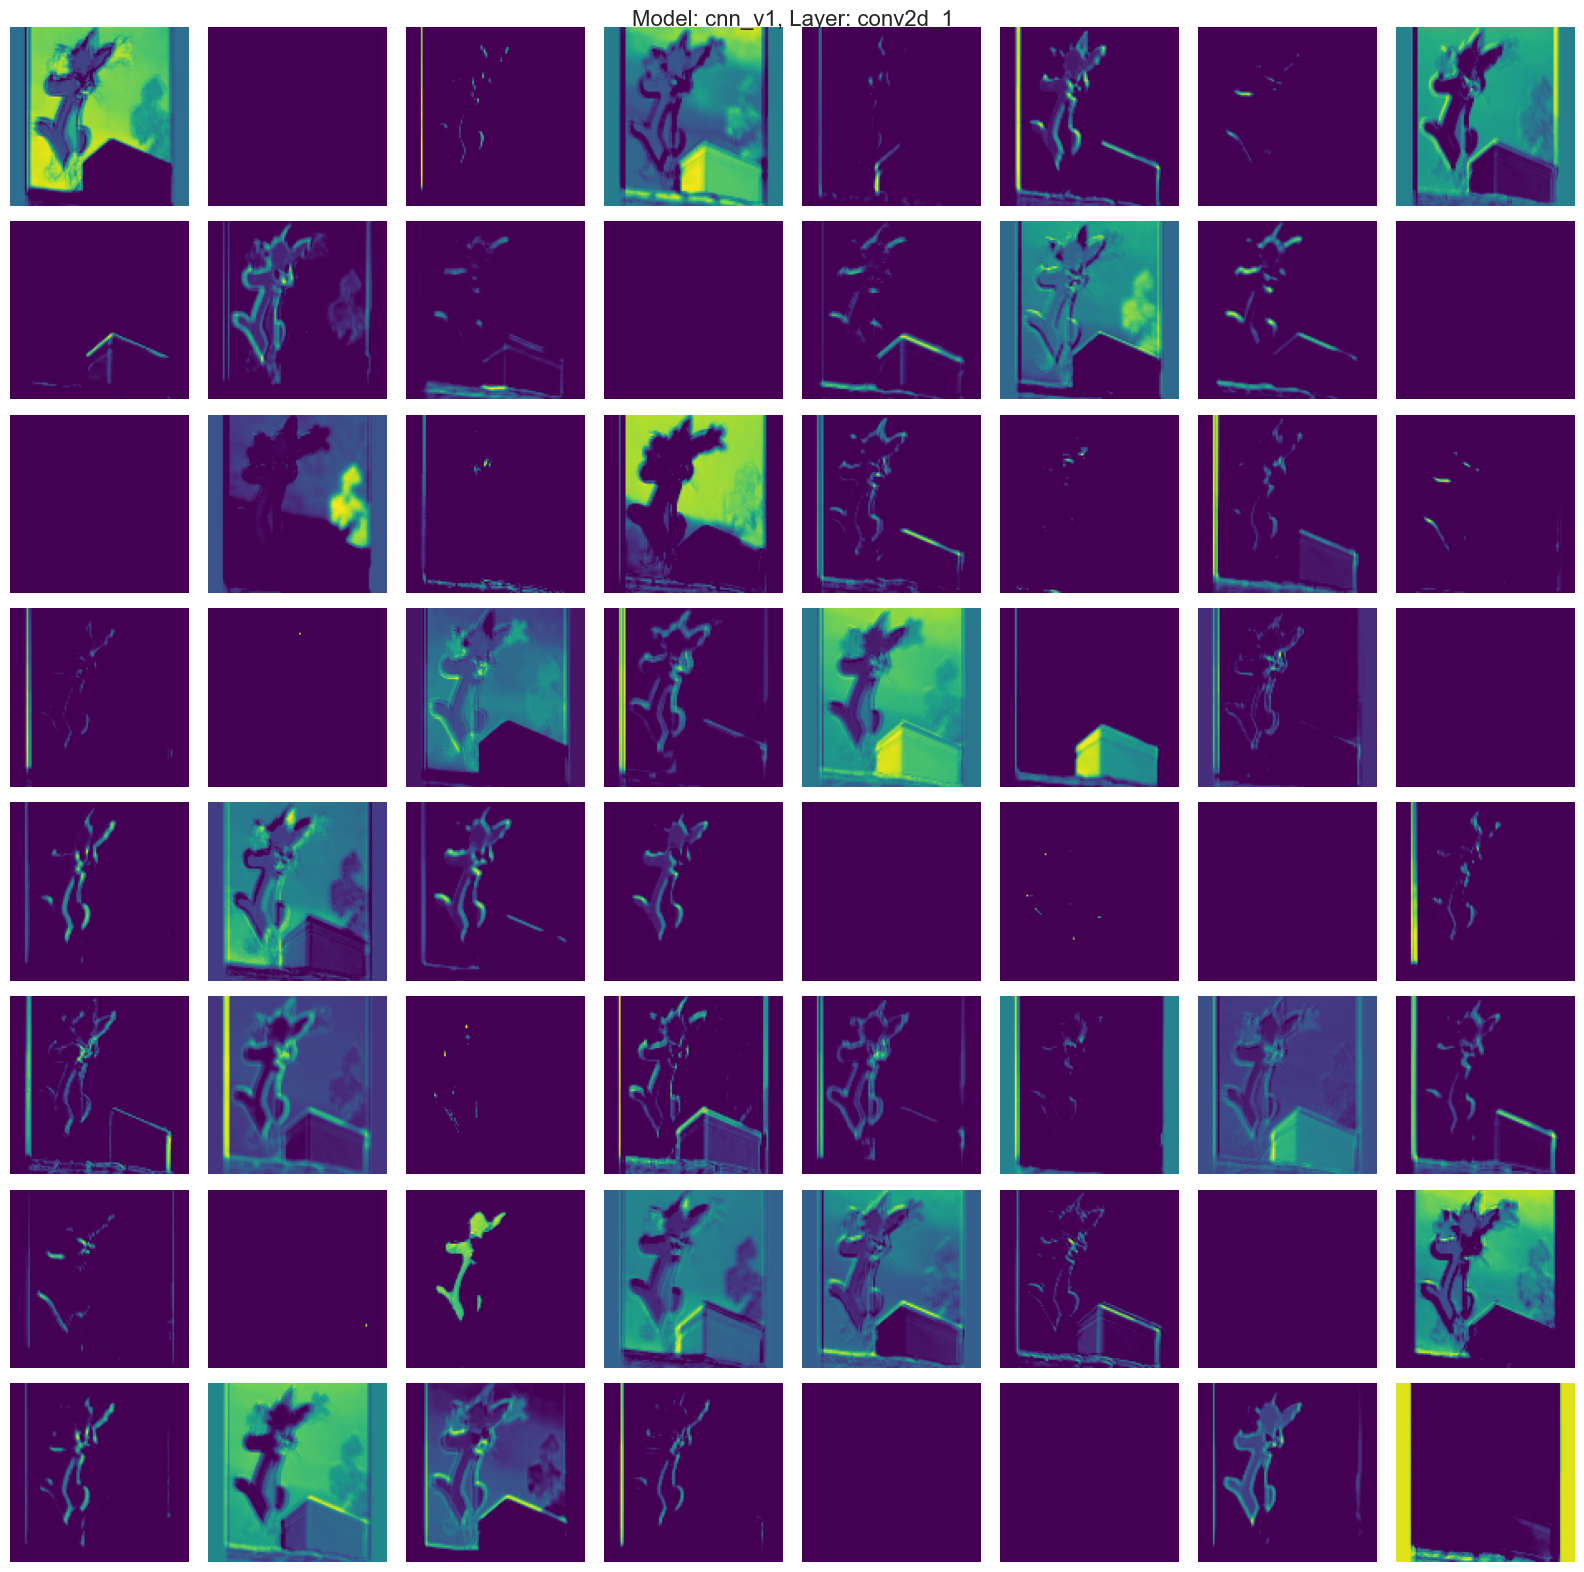

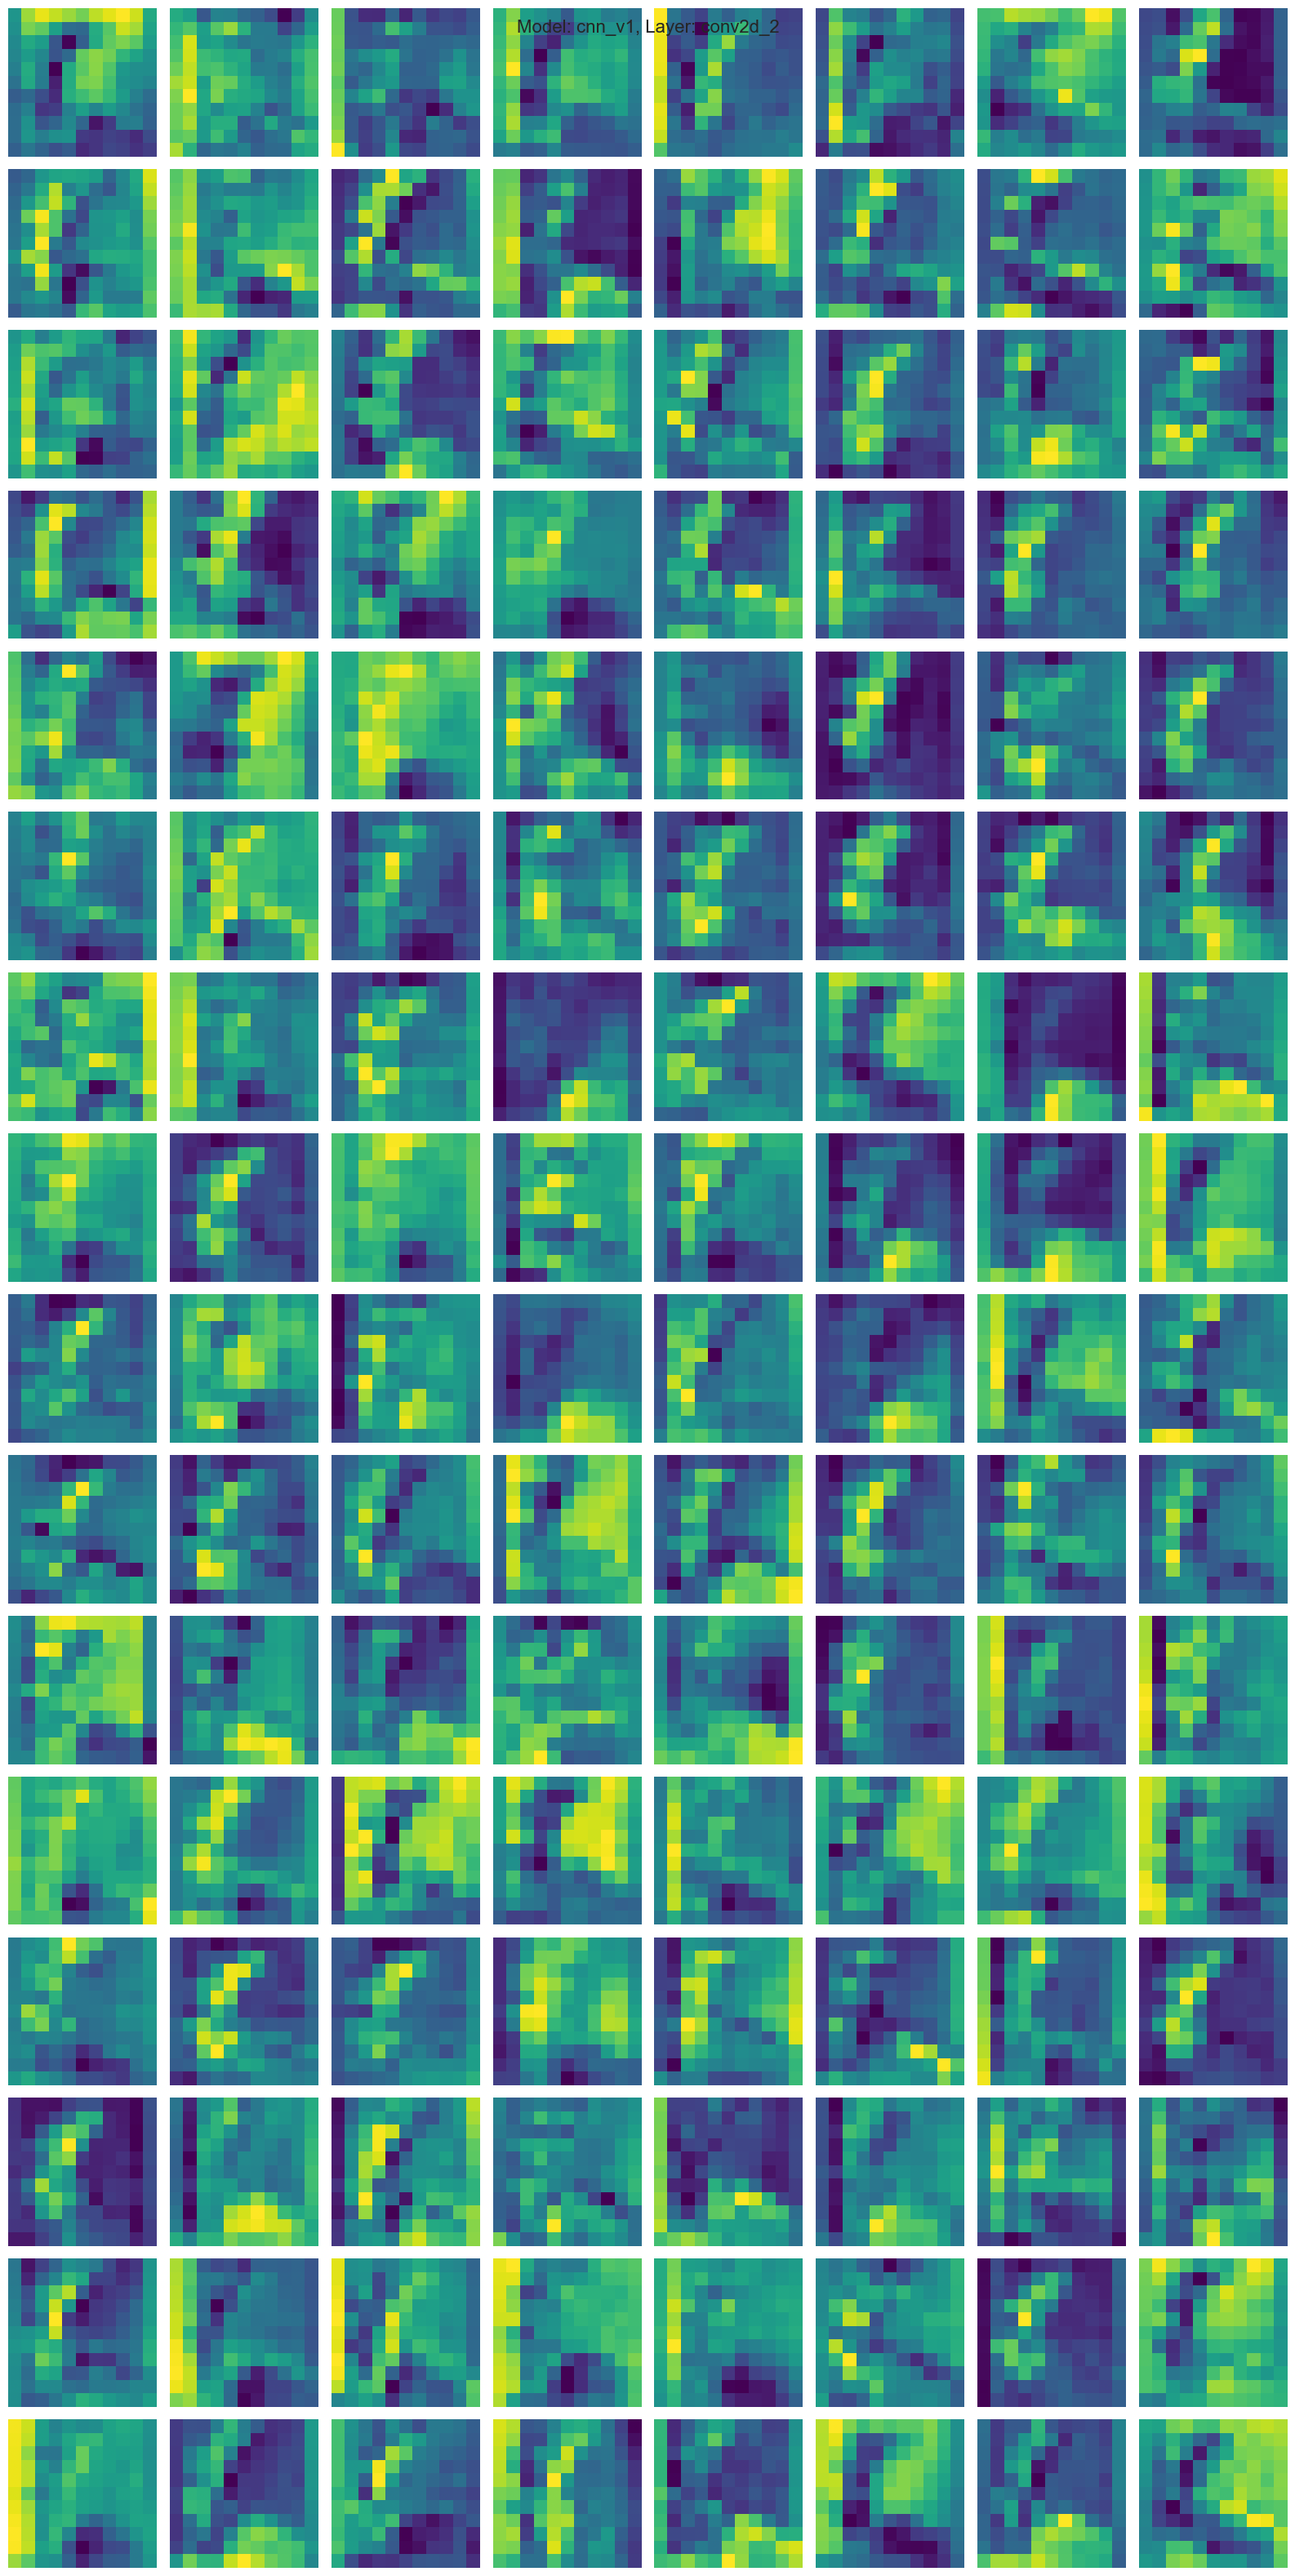

In [ ]:
idx = 17
sinple_input_image = train_pure_generator[0][0][idx]
sinple_input_class = train_pure_generator[0][1][idx]
N_COLS = 8

plt.figure(figsize=(N_COLS * 2, 2))
plt.imshow(sinple_input_image)
plt.title(f"Input Image, Class: {label_encoder.classes_[sinple_input_class]}", fontsize=16)
plt.axis('off')
plt.tight_layout
plt.show()

for custom_model in models_list:
    print(f"Model: {custom_model.name}")

    model = custom_model.model

    output_dict = explain_visualize_intermediate_features(model, sinple_input_image)

    for layer_name, output in output_dict.items():
        n_filters = output.shape[-1]
        n_rows = (n_filters + N_COLS - 1) // N_COLS

        fig, axs = plt.subplots(n_rows, N_COLS, figsize=(N_COLS * 2, n_rows * 2))
        fig.suptitle(f"Model: {custom_model.name}, Layer: {layer_name}", fontsize=16)

        for i in range(n_rows * N_COLS):
            if i < n_filters:
                axs[i // N_COLS, i % N_COLS].imshow(output[0, :, :, i], cmap='viridis')
                axs[i // N_COLS, i % N_COLS].axis('off')
            else:
                axs[i // N_COLS, i % N_COLS].axis('off')

        plt.tight_layout()
        plt.show()
    

## intermediate kernels

In [ ]:
def explain_intermediate_kernel(model, layer_name, filter_index=0):
    filter_index = int(filter_index)

    # Create a submodel that outputs the target layer
    submodel = tf.keras.Model(inputs=model.inputs,
                              outputs=model.get_layer(layer_name).output)

    # Start from random noise image
    input_img_data = tf.random.uniform((1, *IMG_SHAPE))

    # Optimization loop
    step = 1.0
    for i in range(30):
        with tf.GradientTape() as tape:
            tape.watch(input_img_data)
            activation = submodel(input_img_data)
            loss = tf.reduce_mean(activation[..., filter_index])
        grads = tape.gradient(loss, input_img_data)
        grads = grads / (tf.sqrt(tf.reduce_mean(tf.square(grads))) + 1e-5)
        input_img_data = input_img_data + grads * step

    # Convert to displayable image
    img = input_img_data[0].numpy()
    img -= img.mean()
    img /= (img.std() + 1e-5)
    img *= 64
    img += 128
    img = np.clip(img, 0, 255).astype('uint8')
    return img


Model: cnn_v1
  Layer: conv2d, Filters: 32
    Generating filter 0
    Generating filter 1
    Generating filter 2
    Generating filter 3
    Generating filter 4
    Generating filter 5
    Generating filter 6
    Generating filter 7
    Generating filter 8
    Generating filter 9
    Generating filter 10
    Generating filter 11
    Generating filter 12
    Generating filter 13
    Generating filter 14
    Generating filter 15
    Generating filter 16
    Generating filter 17
    Generating filter 18
    Generating filter 19
    Generating filter 20
    Generating filter 21
    Generating filter 22
    Generating filter 23
    Generating filter 24
    Generating filter 25
    Generating filter 26
    Generating filter 27
    Generating filter 28
    Generating filter 29
    Generating filter 30
    Generating filter 31


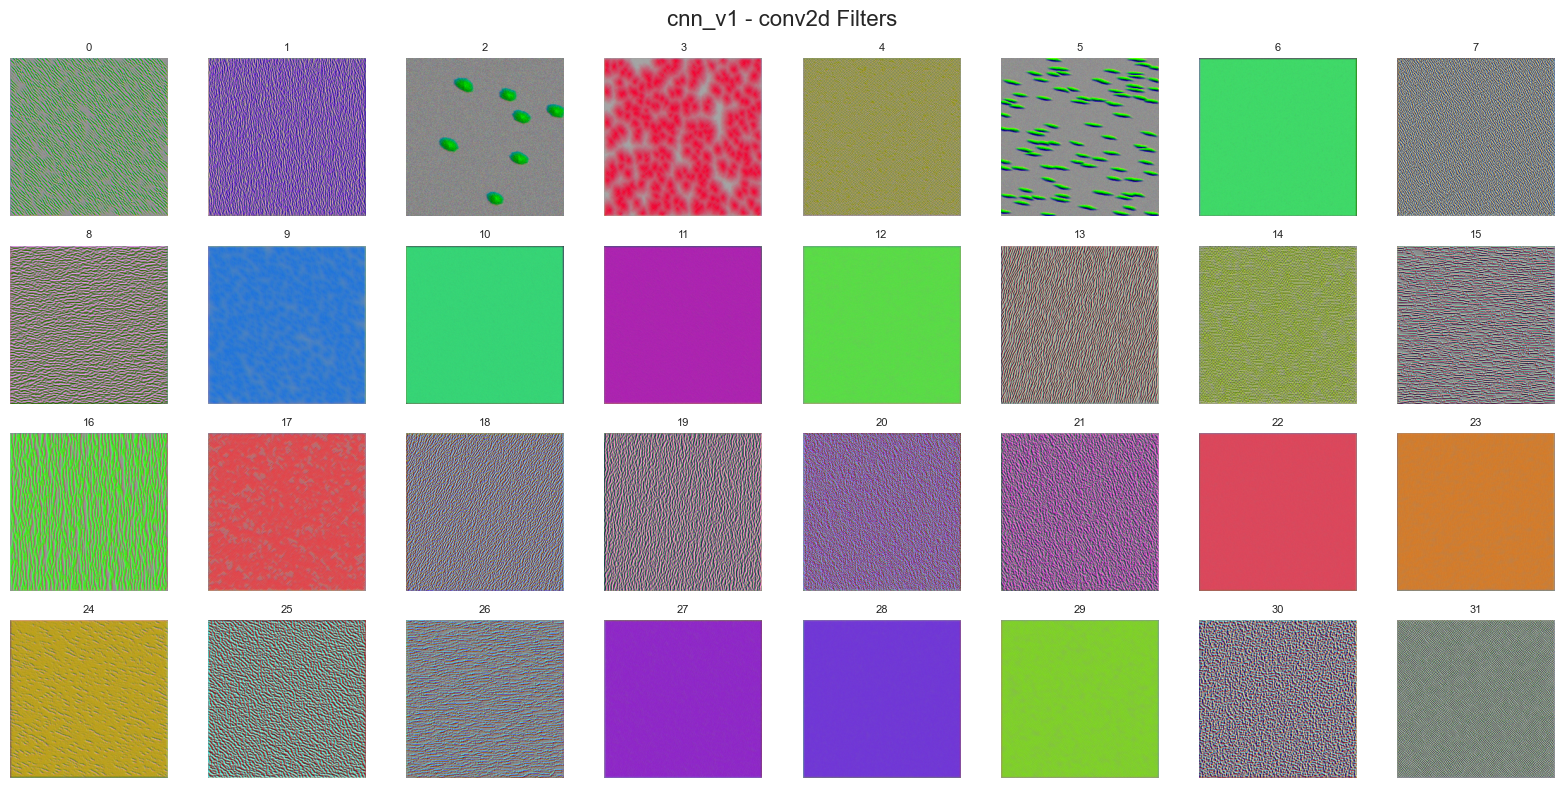

In [ ]:
N_COLS = 8  

for custom_model in models_list:
    print(f"Model: {custom_model.name}")

    model = custom_model.model
    model_conv_layers = [layer for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)]

    #jsut use 1 conv layer
    model_conv_layers = model_conv_layers[0:1]

    for layer in model_conv_layers:
        layer_name = layer.name
        n_filters = layer.filters
        print(f"  Layer: {layer_name}, Filters: {n_filters}")

        n_rows = int(np.ceil(n_filters / N_COLS))
        fig, axes = plt.subplots(n_rows, N_COLS, figsize=(N_COLS*2, n_rows*2))
        axes = axes.flatten()  # flatten in case of multiple rows

        for filter_index in range(n_filters):
            print(f"    Generating filter {filter_index}")
            img = explain_intermediate_kernel(model, layer_name, filter_index=filter_index)
            axes[filter_index].imshow(img)
            axes[filter_index].axis('off')
            axes[filter_index].set_title(f"{filter_index}", fontsize=8)

        # Hide any empty subplots
        for i in range(n_filters, len(axes)):
            axes[i].axis('off')

        plt.suptitle(f"{custom_model.name} - {layer_name} Filters", fontsize=16)
        plt.tight_layout()
        plt.show()


## gradcam

In [ ]:
# import tensorflow as tf
# import numpy as np

# def explain_grad_cam(model, img_array, last_conv_layer_name, class_index=None):
#     # Ensure img_array is a single image with batch dimension
#     if len(img_array.shape) == 3:
#         img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    
#     # Verify the layer exists
#     try:
#         last_conv_layer = model.get_layer(last_conv_layer_name)
#     except ValueError:
#         raise ValueError(f"Layer '{last_conv_layer_name}' not found in the model.")

#     # Create a model that maps input to the last conv layer and predictions
#     grad_model = tf.keras.models.Model(
#         [model.inputs],
#         [last_conv_layer.output, model.outputs]
#     )

#     with tf.GradientTape() as tape:
#         # Forward pass
#         conv_outputs, predictions = grad_model(img_array, training=False)
        
#         # Remove batch dimension
#         # conv_outputs = conv_outputs[0]  # Shape: (height, width, channels)
#         predictions = predictions[0]    # Shape: (num_classes,)

#         # Debug: Print predictions
#         print(f"Predictions: {predictions.numpy()}")

#         # If class_index is not provided, use the predicted class
#         if class_index is None:
#             class_index = tf.argmax(predictions).numpy()
#         else:
#             # Validate class_index
#             if class_index < 0 or class_index >= predictions.shape[-1]:
#                 raise ValueError(f"Invalid class_index {class_index}. Must be between 0 and {predictions.shape[-1] - 1}.")

#         # Select the output for the specified class

#         print(f"Using class index: {class_index}")
#         class_output = predictions[class_index]

#         # Compute gradients of the class output w.r.t. conv layer output
#         grads = tape.gradient(class_output, conv_outputs)

#         # Check if gradients are None
#         if grads is None:
#             raise ValueError("Gradients are None. Ensure the class output depends on the convolutional layer output.")

#         # Compute channel-wise mean of gradients
#         pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

#         # Weight the conv layer output by the importance of each channel
#         heatmap = tf.reduce_mean(conv_outputs * pooled_grads, axis=-1)

#         # Normalize the heatmap
#         heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)



In [ ]:
# heatmap, overlay = explain_grad_cam(models_list[0].model, train_pure_generator[0][0][12], 'conv2d_2', class_index=3)
# plt.imshow(overlay)